In [1]:
import matplotlib
import pandas as pd
import numpy as np
import scipy.stats as si
import sympy as sy
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import norm
pd.options.display.max_columns = None

In [2]:
logins = pd.read_json('logins.json')

In [4]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
len(logins)

93142

In [6]:
logins.login_time.describe()

count                   93142
unique                  92265
top       1970-02-12 11:16:53
freq                        3
first     1970-01-01 20:12:16
last      1970-04-13 18:57:38
Name: login_time, dtype: object

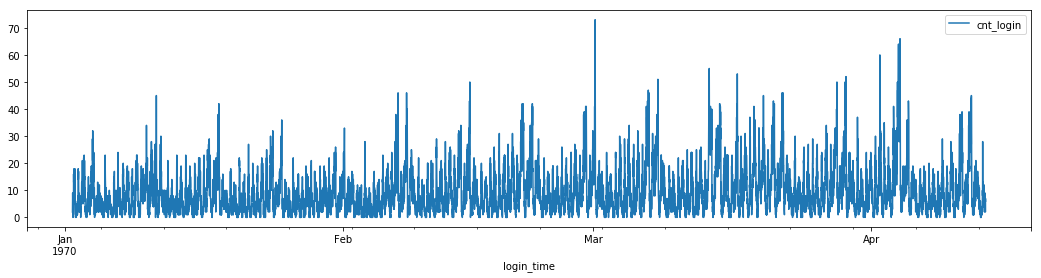

In [8]:
logins['cnt_login'] = 1
logins.set_index('login_time').resample('15min').count().plot(figsize=(18,4))

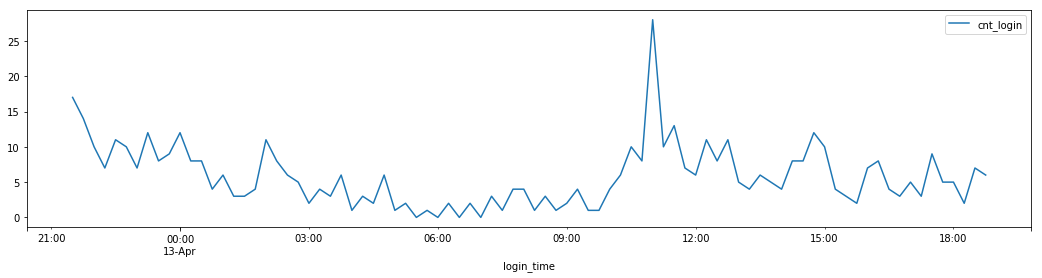

In [9]:
logins[-500:].set_index('login_time').resample('15min').count().plot(figsize=(18,4))

In [10]:
logins_df = logins
logins_df['15_min']=logins['login_time'].dt.round('15min')
logins_df['date'] = logins_df['login_time'].dt.date
logins_df['hour'] = logins_df['15_min'].dt.time
logins_df['count'] = 1

In [11]:
daily_by_year_trends = pd.DataFrame(logins_df['count'].groupby([logins_df['date'],logins_df['hour']]).sum())
daily_by_year_trends[0:5]

count
date       hour           
1970-01-01 00:00:00      6
           20:15:00      6
           20:30:00      8
           20:45:00      7
           21:00:00      3

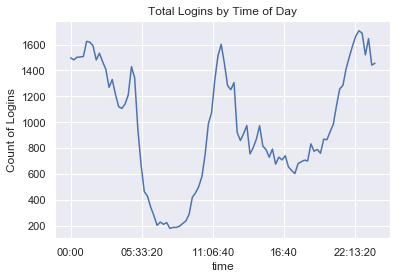

In [12]:
# Show sum of total logins at each time of the day
daily_trends = pd.crosstab(logins_df['hour'],logins_df['count'])
sns.set()
plt.plot(daily_trends)
plt.title('Total Logins by Time of Day')
plt.ylabel('Count of Logins')
plt.show()

Logins tend to dip just before 5:30 and spike back up are 11:00.

Part 2 - Experiment and metrics design 

The    neighboring     cities    of    Gotham    and    Metropolis    have     complementary     circadian     rhythms:     on  weekdays,    Ultimate    Gotham     is    most     active    at    night,    and    Ultimate    Metropolis     is    most    active  during     the    day.  

On    weekends,     there     is     reasonable    activity     in    both     cities.    However,    a     toll    bridge,     with     a     two  ­way     toll,    between     the     two     cities     causes    driver    partners     to     tend  to    be    exclusive     to    each     city.     The     Ultimate    managers    of     city    operations     for     the     two     cities    have  proposed    an    experiment     to     encourage    driver    partners     to    be    available     in    both     cities,    by  reimbursing    all     toll     costs. 

1. What    would     you     choose     as     the     key    measure    of     success    of     this    experiment     in  encouraging    driver     partners     to     serve    both     cities,    and    why    would     you     choose     this    metric?

Tracking the count of toll bridge usage for driver partners will allow us to compare usage before the proposed toll reimbursement and after. If we see a significant increase in toll bridge usage after the change, this is evidence that the toll reimbursements are effective in making driver partners more available in both cities.

2. Describe    a    practical     experiment     you    would    design     to     compare     the    effectiveness    of     the  proposed     change     in     relation     to     the     key    measure    of     success.    Please    provide    details     on:

a. how     you    will     implement     the    experiment

b. what     statistical     test(s)     you    will     conduct     to     verify     the     significance    of     the  observation

c. how     you    would     interpret     the     results    and    provide     recommendations     to     the     city  operations     team    along    with    any     caveats.

a. Track the number of driver partners using the toll bridge after implementing the reimbursement policy. Compare that to the data already gathered on toll bridge usage.

b. I would suggest a t-test on the difference in mean count of toll bridge usage before and after the policy change.

c. If we setup the hypothesis like below:

Where, $\mu_a =$ Before implementation of toll reimbursement

and

$\mu_b =$ After implementation of toll reimbursement

$H_o: \mu_b - \mu_a = 0$

$H_a: \mu_b - \mu_a > 0$

Then, we can determine if there is a statistically significant difference between the two scenarios.

In [13]:
#ultimate = pd.read_json('ultimate_data_challenge.json',orient='records')
import json
with open('ultimate_data_challenge.json', 'r') as datafile:
    data = json.load(datafile)
df0 = pd.DataFrame(data)

In [14]:
len(df0)

50000

In [15]:
df0.isna().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
dtype: int64

In [16]:
df0.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [17]:
# List of columns with missing values
nan_cols = ['avg_rating_by_driver','avg_rating_of_driver']

In [18]:
# Replace nan with mean in ratings and unknown for phone category
df0[nan_cols] = df0.loc[:,nan_cols].fillna(df0.mean())
df0['phone'] = df0['phone'].fillna('unknown')

In [19]:
df0.isnull().sum()

avg_dist                  0
avg_rating_by_driver      0
avg_rating_of_driver      0
avg_surge                 0
city                      0
last_trip_date            0
phone                     0
signup_date               0
surge_pct                 0
trips_in_first_30_days    0
ultimate_black_user       0
weekday_pct               0
dtype: int64

In [20]:
df = df0

In [22]:
from datetime import datetime, timedelta
end_window = datetime.strptime(df.last_trip_date.max(), '%Y-%m-%d')
end_window

datetime.datetime(2014, 7, 1, 0, 0)

In [24]:
#datetime.strptime(df.last_trip_date[0], '%Y-%m-%d')
start_window = end_window - timedelta(days=30)

In [25]:
# Set active_indicator = 1 if last_trip_date was within the last 30 days
df['active_indicator'] = [1 if datetime.strptime(date, '%Y-%m-%d') >= start_window else 0  for date in df.last_trip_date]

In [26]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_indicator
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


First let's look at an overall view of the percentage of retention for Ultimate users.

C:\Users\regru\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


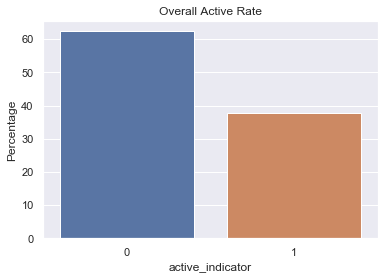

In [30]:
sns.set()
sns.barplot(x='active_indicator',y='active_indicator',data=df, estimator=lambda x: len(x) / len(df) * 100,orient="v")
plt.ylabel('Percentage')
plt.title('Overall Active Rate')
plt.show()

Next, we will look at breaking down each of the categorical variables and looking at retention rate within each category.

In [38]:
iphone = df[df.phone == 'iPhone']
android = df[df.phone == 'Android']
unknown = df[df.phone == 'unknown']
black_user = df[df.ultimate_black_user == True]
non_black_user = df[df.ultimate_black_user == False]
kings_landing = df[df.city == "King's Landing"]
astapor = df[df.city == 'Astapor']
winterfell = df[df.city == 'Winterfell']

C:\Users\regru\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


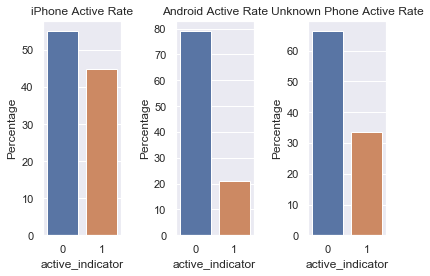

In [44]:
f, axes = plt.subplots(1, 3)
sns.barplot(x='active_indicator',y='active_indicator',data=iphone, estimator=lambda x: len(x) / len(iphone) * 100,orient="v",ax=axes[0]).set(ylabel='Percentage',title='iPhone Active Rate')
sns.barplot(x='active_indicator',y='active_indicator',data=android, estimator=lambda x: len(x) / len(android) * 100,orient="v",ax=axes[1]).set(ylabel='Percentage',title='Android Active Rate')
sns.barplot(x='active_indicator',y='active_indicator',data=unknown, estimator=lambda x: len(x) / len(unknown) * 100,orient="v",ax=axes[2]).set(ylabel='Percentage',title='Unknown Phone Active Rate')
plt.tight_layout()
plt.show()

C:\Users\regru\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


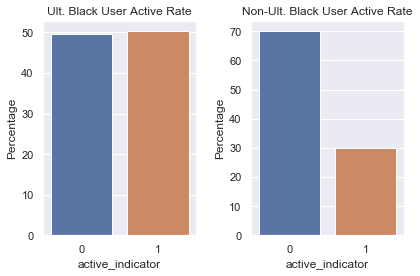

In [45]:
f, axes = plt.subplots(1, 2)
sns.barplot(x='active_indicator',y='active_indicator',data=black_user, estimator=lambda x: len(x) / len(black_user) * 100,orient="v",ax=axes[0]).set(ylabel='Percentage',title='Ult. Black User Active Rate')
sns.barplot(x='active_indicator',y='active_indicator',data=non_black_user, estimator=lambda x: len(x) / len(non_black_user) * 100,orient="v",ax=axes[1]).set(ylabel='Percentage',title='Non-Ult. Black User Active Rate')
plt.tight_layout()
plt.show()

C:\Users\regru\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


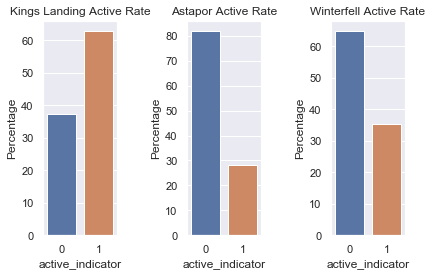

In [48]:
f, axes = plt.subplots(1, 3)
sns.barplot(x='active_indicator',y='active_indicator',data=kings_landing, estimator=lambda x: len(x) / len(kings_landing) * 100,orient="v",ax=axes[0]).set(ylabel='Percentage',title='Kings Landing Active Rate')
sns.barplot(x='active_indicator',y='active_indicator',data=astapor, estimator=lambda x: len(x) / len(android) * 100,orient="v",ax=axes[1]).set(ylabel='Percentage',title='Astapor Active Rate')
sns.barplot(x='active_indicator',y='active_indicator',data=winterfell, estimator=lambda x: len(x) / len(winterfell) * 100,orient="v",ax=axes[2]).set(ylabel='Percentage',title='Winterfell Active Rate')
plt.tight_layout()
plt.show()

And finally, before fitting any models, I want to look relationships between all variables, including numeric variables, to each other and to the label we are trying to predict.

C:\Users\regru\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\regru\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\regru\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\regru\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


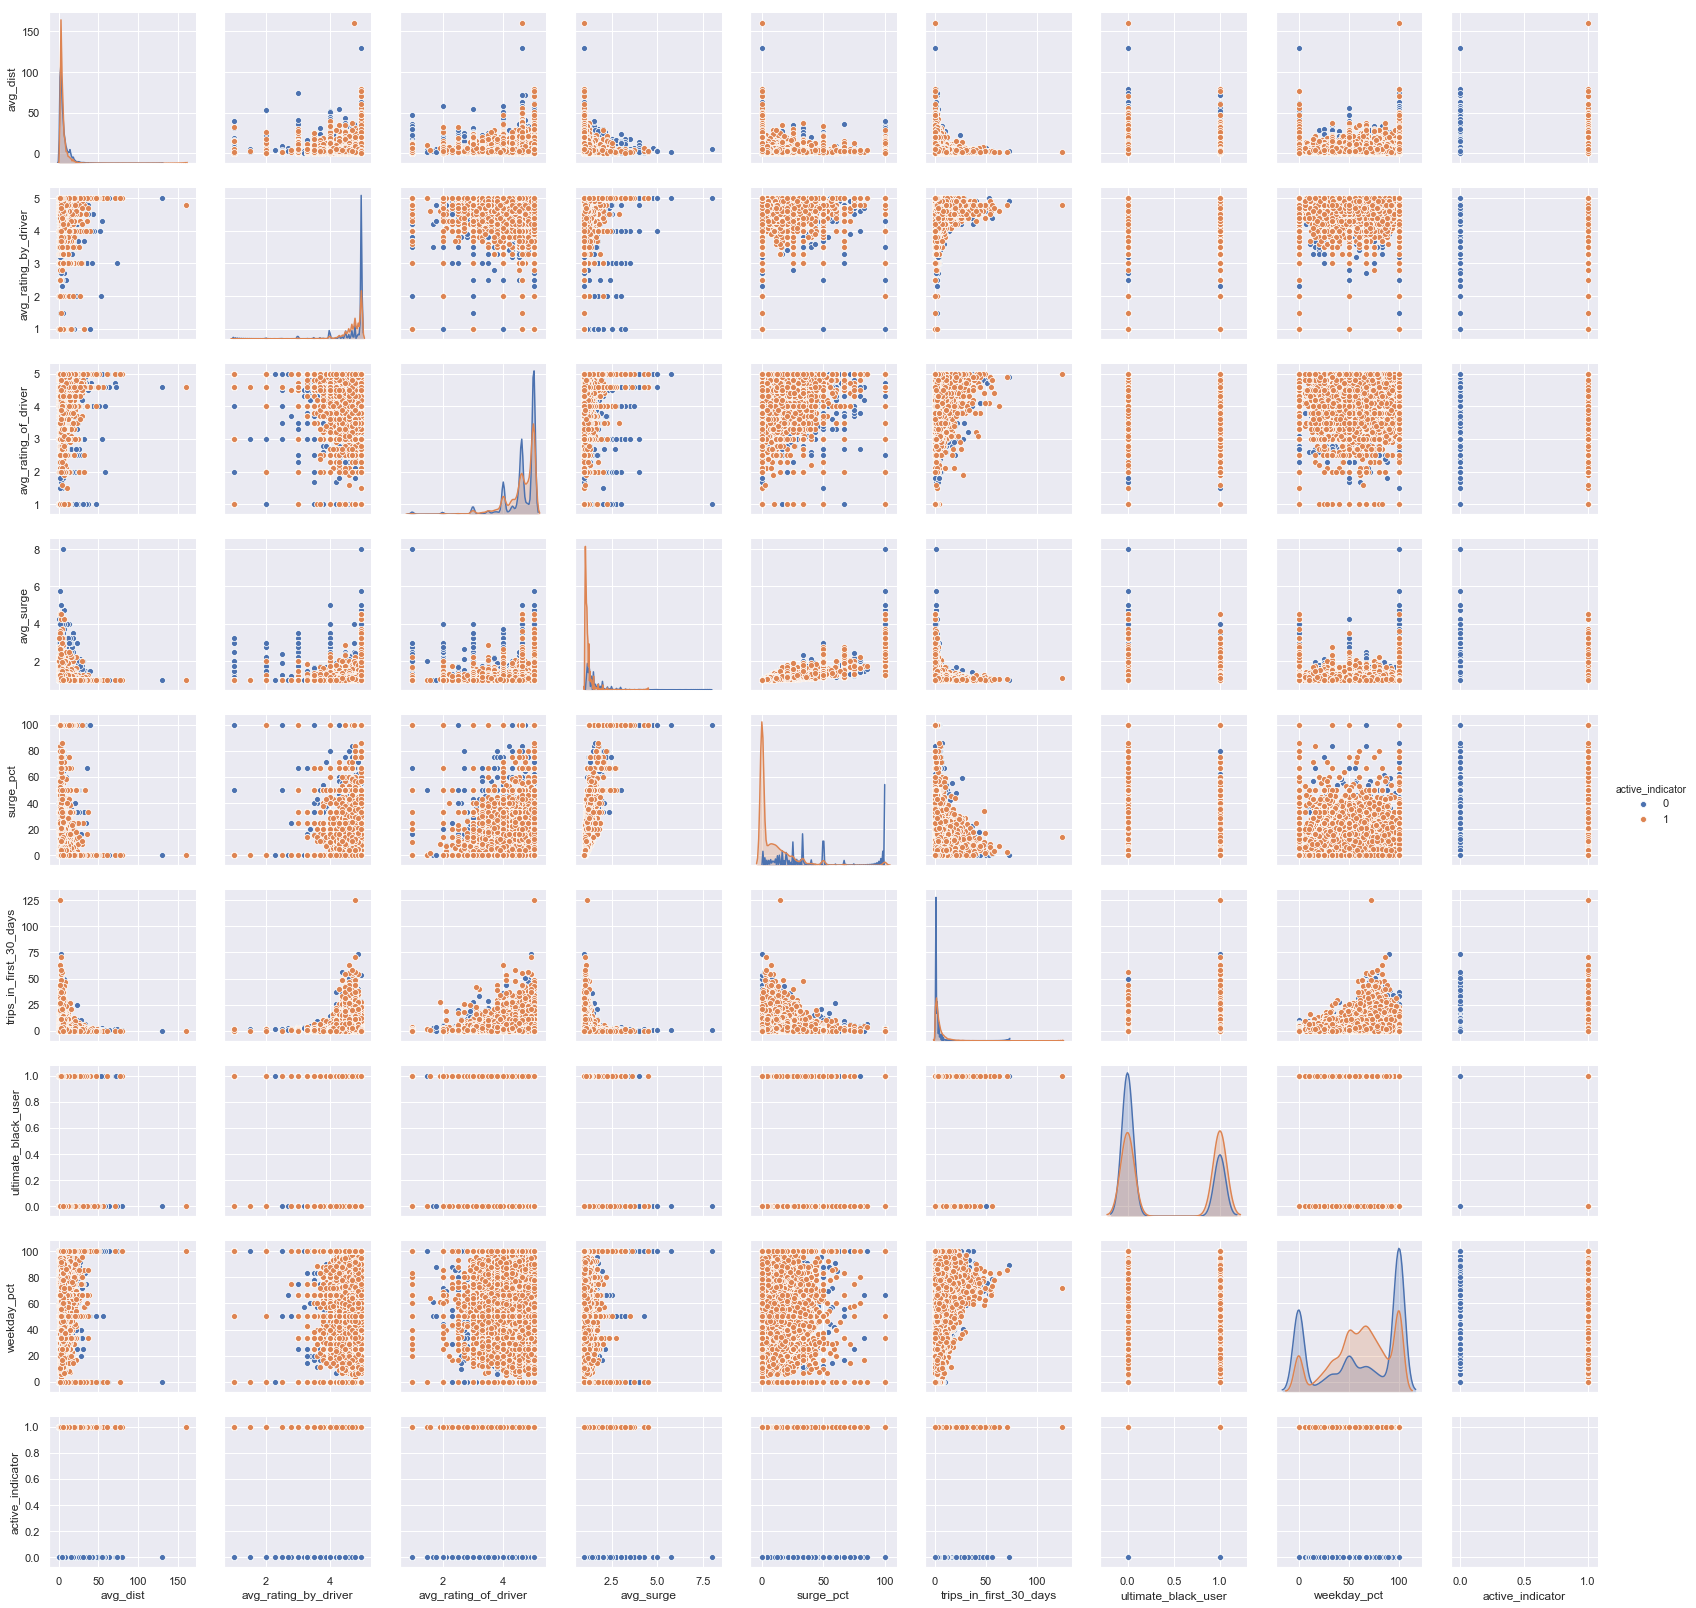

In [94]:
sns.set(font_scale = 1)
sns.pairplot(df, hue="active_indicator")
plt.show()

Now let's fit a predictive model.I will use the CatBoost classifier, because it has shown to get optimal out of the box results even compared to most models after parameter tuning.

In [65]:
#encode categorical vars
cat_features = ['city','phone','ultimate_black_user']
df_dummy = pd.get_dummies(df[cat_features],columns=cat_features,drop_first=True)
df_col_numeric = ['active_indicator','avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','surge_pct','trips_in_first_30_days','weekday_pct']
df_mod = pd.concat([df_dummy,df[df_col_numeric]],axis=1)
df_mod.head()

,city_King's Landing,city_Winterfell,phone_iPhone,phone_unknown,ultimate_black_user_True,active_indicator,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
0,1,0,1,0,1,1,3.67,5.0,4.7,1.10,15.4,4,46.2
1,0,0,0,0,0,0,8.26,5.0,5.0,1.00,0.0,0,50.0
2,0,0,1,0,0,0,0.77,5.0,4.3,1.00,0.0,3,100.0
3,1,0,1,0,1,1,2.36,4.9,4.6,1.14,20.0,9,80.0
4,0,1,0,0,0,0,3.13,4.9,4.4,1.19,11.8,14,82.4


In [69]:
# Separate label and features
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
features = df_mod.drop(columns=['active_indicator'])
label = df.active_indicator
# Split to training and test sets
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(features.values,label.values,random_state=512)

In [71]:
#catboost
from catboost import Pool, CatBoostClassifier
catb_mod = CatBoostClassifier(silent=True)
#train the model
catb_mod.fit(xtrain,ytrain)
# make the prediction using the resulting model
catb_preds = catb_mod.predict(xtest)

In [86]:
#accuracy
accuracy_score(ytest, catb_preds)

0.79152

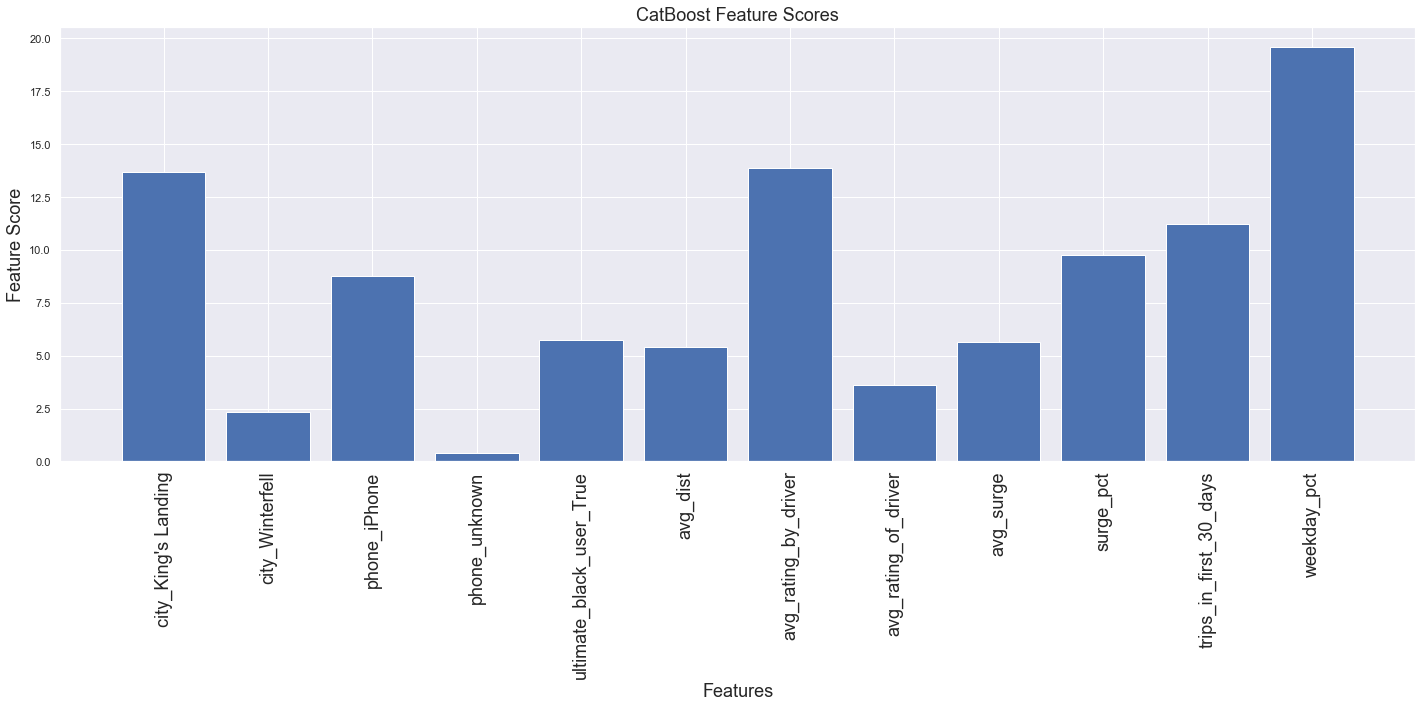

In [93]:
feat_scores = catb_mod.get_feature_importance()
sns.set()
plt.figure(figsize=(20,10))
plt.rc('xtick',labelsize=18)
plt.bar(range(len(features.columns)), feat_scores)
plt.xticks(range(len(features.columns)), features, rotation='vertical')
plt.title('CatBoost Feature Scores', fontsize=18)
plt.xlabel('Features', fontsize=18)
plt.ylabel('Feature Score', fontsize=18)
plt.tight_layout()
plt.show()

This model shows weekday_pct as the most predictive feature for retention among Ultimate users.

In [73]:
# confusion matrix
pd.crosstab(ytest, catb_preds, rownames=['Actual'], colnames=['Predicted'], margins=True, normalize='all')

Predicted,0.0,1.0,All
Actual,,,
0,0.54016,0.08464,0.6248
1,0.12384,0.25136,0.3752
All,0.66400,0.33600,1.0000


In [74]:
# confusion matrix
pd.crosstab(ytest, catb_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
Actual,,,
0,6752,1058,7810
1,1548,3142,4690
All,8300,4200,12500


In [96]:
# 5-fold cross validation using mean and stdev AUC value of ROC
def np_kfold_roc(clf, x, y,nfold=5):
    result = 0
    result_sq = 0
    for train, validation in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += roc_auc_score(y[validation], clf.predict_proba(x[validation])[:,1])# evaluate score function on held-out data
    avg_auroc = result/nfold 
    for train_1, validation_1 in KFold(nfold).split(x):
        result_sq += (roc_auc_score(y[validation], clf.predict_proba(x[validation])[:,1]) - avg_auroc)**2
    std_auroc = result_sq/nfold
    return (avg_auroc,np.sqrt(std_auroc))
np_kfold_roc(catb_mod,xtrain,ytrain) 

(0.8576226362671457, 0.0007040630591321762)

C:\Users\regru\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


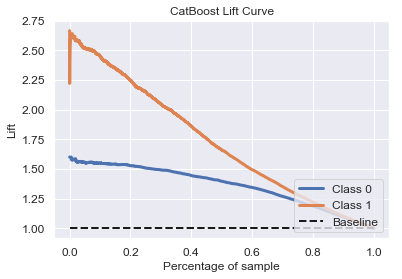

In [79]:
# Lift Graph
import scikitplot as skplt
skplt.metrics.plot_lift_curve(y_true=ytest, y_probas=catb_mod.predict_proba(xtest))
sns.set()
plt.title('CatBoost Lift Curve')
plt.show()

In [80]:
# Calculate ROC curve for model
from sklearn.metrics import roc_curve, auc
fpr1, tpr1, threshold1 = roc_curve(ytest, catb_mod.predict_proba(xtest)[:,1])
roc_auc1 = auc(fpr1, tpr1)

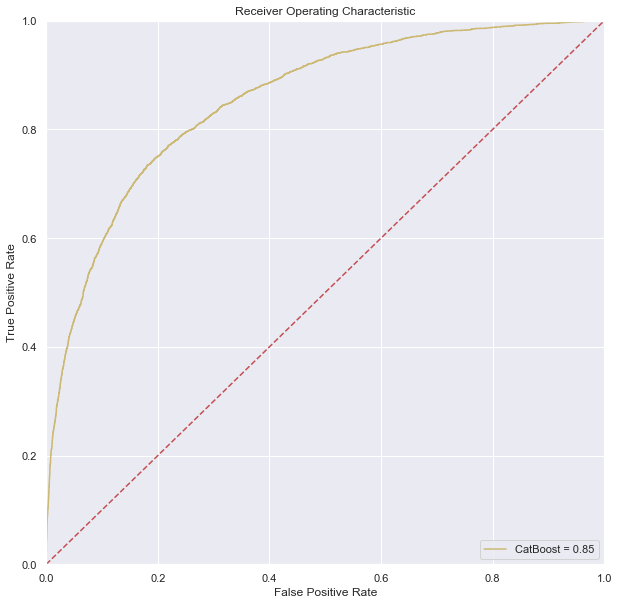

In [82]:
# Plot ROC curve
sns.set()
plt.rcParams["figure.figsize"] = (10,10)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'y', label = 'CatBoost = %0.2f' % roc_auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Results and Insights

After looking at the data and building a predictive model, in order to improve ridership retention, I would suggest focused marketing in King's Landing, pushing for riders to become "Ultimate Black Users" and to focus on iPhone owners. The data suggests that the retention rate in these three categories are significantly higher than their respective counter parts.